*in the name of Allah*

# Description:
The article was about heart rate prediction.
I got 3 minutes as input in this code and predict 5 minutes as output. We have the heart rate for every 0.5 seconds in the data set. So for getting 3 minutes as input, our input shape will be like this: 60(60 seconds per minute) * 3(minutes) * 2(for 1 second) = 360,  and for output shape(predict 5 minutes), it will be : 60 * 5 * 2 = 600.

* Before starting to work with our data, we have to check if our data is stationary or not.
For this part, I checked it in three ways: 
  1. Histogram plot to check if we have normal distribution data or not.
  2. calculate mean and variance in parts of data to understand whether our mean or variance in our data is alike or not.
  3. Dickey-Fuller test

  If our data wasn't stationary, we had to make it stationary (It was stationary.)

* After that, we have to scale our data between [-1,1] 
* There are some functions that I will describe here:
  *   to_supervised : 
     this function will take our dataset, make windows and predictions, and make an array containing two columns (3 minutes input, 5minutes output).
And the next window and prediction will be in the next row.
  *   split_dataset: It will take our dataset, supervise data via the to_supervised function, and split it to train and test.

These parts of code were about preparing data for building a model.

The next step is about building a model.  
  (first, I made my model without Keras tuner. and then I used Keras tuner )
  * Functions: 
    * build_model: it takes one argument name hp and prepares a model to tune model parameters. number of neurons is in the range (10, 500), and the dropout value is in the range (0.1, 0.9)

    * tune: it defines parameters(train, test,  model name, and directory address, where our result will save). It will find the best parameters and build a model with the parameters.

The next part is about evaluation.we used rmse for evaluation mertric.
  * Functions:
    * rmse: it calculates rmse score.
    * evaluate_model: first, it runs the build_model function, then tune parameters and build model,  and at last calculates rmse score.

# Report
In the following, I have reported the values calculated in the code by different models.

##RNN Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |        410         |       0.5       |   0.506
        2        |     [394,346]      |    [0.7,0.2]    |   0.515
        3        |    [362,90,138]    |  [0.4,0.2,0.5]  |   0.510
```



##LSTM Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |         74         |       0.7       |   0.481
        2        |      [106,378]     |    [0.7,0.9]    |   0.508
        3        |     [282,90,346]   |  [0.5,0.7,0.5]  |   0.438
```



##GRU Report


```
  No. of layers  |    No. of neurons  |     Dropout     |   RMSE
        1        |         122        |       0.7       |   0.482
        2        |       [74,58]      |    [0.8,0.4]    |   0.428
        3        |     [90,42,490]    |  [0.2,0.6,0.1]  |   0.451
```



##BI-LSTM Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |         154        |       0.3       |   0.452
        2        |       [74,58]      |    [0.8,0.4]    |   0.466
        3        |    [346,106,394]   |  [0.2,0.6,0.7]  |   0.501
```



# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

from keras.metrics import RootMeanSquaredError
from keras.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import (SimpleRNN, Dense, LSTM, GRU, Flatten, Dropout, Bidirectional)

!pip install keras-tuner --upgrade
import keras_tuner as kt

#Preprocessing

In [ ]:
df = pd.read_csv("/content/heart-rate-time-series.csv",header=None)

In [ ]:
df.head()

,0
0,91.4634
1,91.4634
2,91.1834
3,91.8788
4,91.1772


In [ ]:
df.describe()

,0
count,1800.000000
mean,96.637474
std,5.687179
min,80.213900
25%,92.418925
50%,98.238450
75%,101.362750
max,104.895000


## Statistical tests


plot dataset

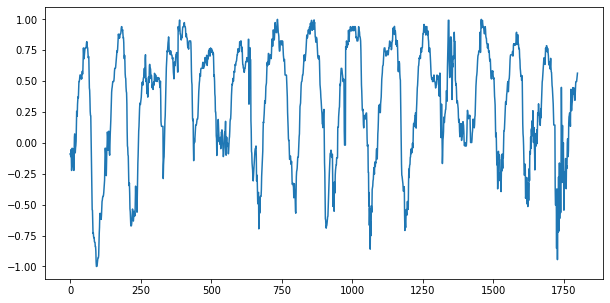

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df)
plt.show()

Histogram plot.

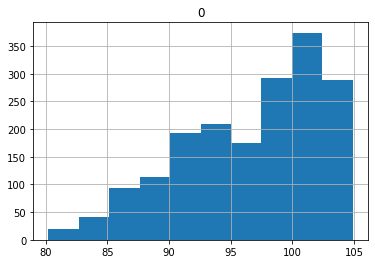

In [ ]:
df.hist()
plt.show()

calculate mean and variance in parts of data, to undrestand that our mean
or variance in our data is alike or not.

in this data we have the same mean and variance,So it looks stationary.



In [ ]:
x = df.values
split = round(len(x)/2)
x1, x2 = x[:split], x[split:]
mean1, mean2 = x1.mean(), x2.mean()
var1, var2 = x1.var(), x2.var()
print("mean1=%f, mean2=%f" % (mean1,mean2))
print("var1=%f, var2=%f" % (var1,var2))

mean1=96.890504, mean2=96.384444
var1=33.904997, var2=30.619018


Dickey-Fuller test

We interpret this result using the p-value from the test. If the p_value is more significant than 0.05, this test fails. And if the p_value is less than 0.05, the test is successful, and our data is stationary.

In [ ]:
x = df.values
x = x.reshape((1800))
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.455368
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Scale and supervised data

In [ ]:
# scale our data between [-1, 1]
s = MinMaxScaler(feature_range=(-1,1))
df = s.fit_transform(df[[0]])

In [ ]:
# convert list of minutes into inputs and outputs,input 
# n_input, outputs:number of time steps returns the data in 
# the overlapping moving window format(3 minutes, 5minutes)

def to_supervised(data, n_input, n_out):
	X, y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X),np.array(y)

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data,n_input,n_out,percent):
	# supervised dataset
	x, y = to_supervised(data,n_input,n_out)
  # split dataset into train and test
	n = int(len(x)*percent)
	train = [x[:n,:], y[:n]]
	test = [x[n:,:], y[n:]]
	return train, test

# Build model

In [ ]:
# build model function 
# number of neurons is in range (10, 500)
# and dropout value is in range (0.1, 0.9)

def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM1 units",min_value=10, max_value=500,step=16), 
			# return_sequences=True
			)
			,input_shape=(n_timesteps, n_features)))
 
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	# model.add(Bidirectional(LSTM(
	# 		units=hp.Int("BILSTM2 units",min_value=10,max_value=500,step=16),
	# 		return_sequences=True
	#  )))
	# model.add(Dropout(
	# 		rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	# ))

	# model.add(Bidirectional(LSTM(
	# 		units=hp.Int("BILSTM3 units",min_value=10,max_value=500,step=16),
	#  )))
	# model.add(Dropout(
	# 		rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	# ))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model

Tune parameters and build model model with theme.

In [ ]:
# find the best parameters and build model with theme
# print scores and save results.
def tune(train,test,name,dir):  
  #prepare data
  x_train, y_train = train[0], train[1]
  x_test, y_test = test[0], test[1]
  project_name, directory = name , dir
  
  #define parameters
  verbose, epochs, batch_size = 0, 5, 16
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

  #configure tuner
  tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory=directory,
    project_name=project_name
	)
  
  #search for best parameters
  tuner.search(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

  #build best model
  models = tuner.get_best_models(num_models=2)
  best_model = models[0]
  best_model.build(input_shape=(n_timesteps, n_features))

  #summery results
  best_model.summary()
  tuner.results_summary()

  return best_model

# Evaluation

In [ ]:
# evaluate a single model
def evaluate_model(train, test,name,dir):
	# compile model
	build_model(kt.HyperParameters())
  
	# tune and fit model
	model = tune(train,test,name,dir)

	# predict test set
	predict = model.predict(test[0])
	xtest = test[0].reshape((test[0].shape[0],test[0].shape[1]))
	predictions = predict
	observation = test[1]
	
  #calculate rmse and scores
	score, scores = rmse(observation,predictions)
	return predict,score, scores

In [ ]:
#calculate rmse for every single prediction
#and calculate rmse overall
def rmse(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(len(actual)):
		# calculate rmse
		mse = mean_squared_error(actual[i], predicted[i])
		rmse = math.sqrt(mse)

		scores.append(rmse)
	# calculate overall RMSE	
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

#RUN and report results

In [ ]:
n_input = 360
n_out = 600
name = "BI-LSTM(1 layer)"
dir = "/content"
# split into train and test
train ,test = split_dataset(df,n_input,n_out,0.7)

# evaluate model
t1 = time.time()
predict, score, scores = evaluate_model(train, test ,name ,dir)
t2 = time.time()
#print score
print('running time : %.2f min'%((t2-t1)/60))
print('%s RMSE : [%.3f]' %(name, score))

Trial 3 Complete [00h 00m 44s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 54s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 308)              192192    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 308)               0         
                                                                 
 dense (Dense)               (None, 600)               185400    
                                                                 
Total params: 377,592
Trainable params: 377,592
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in /content/BI-LSTM(1 layer)
Showing 10 best trials
Trial summary
Hyperpar

#Report results

##RNN Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |        410         |       0.5       |   0.506
        2        |     [394,346]      |    [0.7,0.2]    |   0.515
        3        |    [362,90,138]    |  [0.4,0.2,0.5]  |   0.510
```





```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(SimpleRNN(
			units=hp.Int("RNN1 units",min_value=10, max_value=500,step=16), 
			input_shape=(n_timesteps, n_features),
			return_sequences=True
		))
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(SimpleRNN(
			units=hp.Int("RNN2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(SimpleRNN(
			units=hp.Int("RNN3 units",min_value=10,max_value=500,step=16),
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```



##LSTM Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |         74         |       0.7       |   0.481
        2        |      [106,378]     |    [0.7,0.9]    |   0.508
        3        |     [282,90,346]   |  [0.5,0.7,0.5]  |   0.438
```





```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(LSTM(
			units=hp.Int("lstm1 units",min_value=10, max_value=500,step=16), 
			input_shape=(n_timesteps, n_features),
			return_sequences=True
		))
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(LSTM(
			units=hp.Int("lstm2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(LSTM(
			units=hp.Int("lstm3 units",min_value=10,max_value=500,step=16),
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```



##GRU Report


```
  No. of layers  |    No. of neurons  |     Dropout     |   RMSE
        1        |         122        |       0.7       |   0.482
        2        |       [74,58]      |    [0.8,0.4]    |   0.428
        3        |     [90,42,490]    |  [0.2,0.6,0.1]  |   0.451
```





```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(GRU(
			units=hp.Int("GRU1 units",min_value=10, max_value=500,step=16), 
			input_shape=(n_timesteps, n_features),
			return_sequences=True
		))
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(GRU(
			units=hp.Int("GRU2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(GRU(
			units=hp.Int("GRU3 units",min_value=10,max_value=500,step=16),
	 ))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```



##BI-LSTM Report


```
  No. of layers  |   No. of neurons   |     Dropout     |   RMSE
        1        |         154        |       0.3       |   0.452
        2        |       [74,58]      |    [0.8,0.4]    |   0.466
        3        |    [346,106,394]   |  [0.2,0.6,0.7]  |   0.501
```




```
def build_model(hp):  #prepare model for tuner
	n_timesteps, n_features, n_out = 360, 1, 600
	# define model
	model = Sequential()
	
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM1 units",min_value=10, max_value=500,step=16), 
			return_sequences=True
			)
			,input_shape=(n_timesteps, n_features)))
 
	model.add(Dropout(
			rate=hp.Float("dropout1",min_value=0.1,max_value=0.9,step=0.1)
	 ))
 
	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM2 units",min_value=10,max_value=500,step=16),
			return_sequences=True
	 )))
	model.add(Dropout(
			rate=hp.Float("dropout2",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Bidirectional(LSTM(
			units=hp.Int("BILSTM3 units",min_value=10,max_value=500,step=16),
	 )))
	model.add(Dropout(
			rate=hp.Float("dropout3",min_value=0.1,max_value=0.9,step=0.1)
	))

	model.add(Dense(n_out, activation="relu"))
	model.compile(loss='mse', optimizer='adam',metrics=['accuracy',RootMeanSquaredError()])
	return model
```

